In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import numpy as np
from sklearn.metrics import confusion_matrix

import os
import pandas as pd
import time
import warnings
from tqdm.notebook import tqdm

import librosa
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f"Using device: {device}")

warnings.filterwarnings('ignore')

Using device: cuda


In [2]:
class SpectrogramDataset(Dataset):
    def __init__(self, csv_file, spectrogram_dir, transform=None, target_transform=None):
        self.df = pd.read_csv(csv_file)
        self.spectrograms = spectrogram_dir
        self.transform = transform
        self.target_transform = target_transform
        self.label_map = {
            'Drone': 0,
            'No Drone': 1
        }

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        spectrogram_filename = f"{self.df.iloc[idx, 0][0:-4]}_spectrogram.pt"
        spectrogram_path = os.path.join(self.spectrograms, spectrogram_filename)
        spectrogram = torch.load(spectrogram_path)
        spectrogram = torch.nan_to_num(spectrogram)
        label = self.df.iloc[idx, 1]
        
        return spectrogram, torch.tensor(label)
    

# Usage example
csv_file = "/home/distasiom/Documents/Summer2024/data/complete_dataset.csv"
spectrogram_dir = "/home/distasiom/Documents/Summer2024/data/complete_dataset_spectrograms"

# Define any transformations if needed
transform = None
target_transform = None

dataset = SpectrogramDataset(csv_file, spectrogram_dir, transform=transform, target_transform=target_transform)

In [3]:
train_size = int(.8 * len(dataset))
test_size = int(.75 * (len(dataset) - train_size))
val_size = len(dataset) - train_size - test_size

train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])
print(train_dataset)
print(train_dataset[0])

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
    )

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False
)

(tensor([[[ 0.4198,  0.6644,  0.7896,  ...,  0.4446,  0.5864,  0.5865],
         [ 0.6545,  0.7381,  0.9126,  ...,  0.2800,  0.5626,  0.5945],
         [ 0.7531,  0.9369,  1.0000,  ...,  0.5365,  0.6392,  0.5939],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8923, -0.6954],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8924, -0.6954],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8924, -0.6954]]]), tensor(1))


In [5]:
# Test for all 0 spectrograms
for spectrogram, label in test_loader:
    if(spectrogram.mean() == -1):
        print(spectrogram)

In [9]:
print(train_dataset[7][0].shape)


torch.Size([1, 1025, 87])


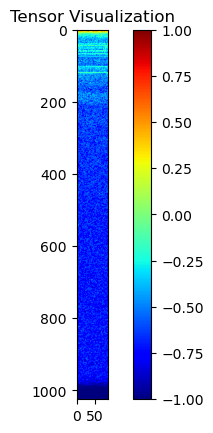

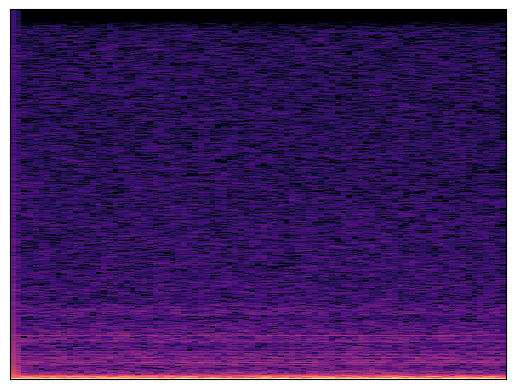

In [10]:
tensor_size = (1,201,442)
i = 3
tensor = train_dataset[i][0][0]
plt.imshow(tensor, cmap='jet')
plt.title('Tensor Visualization')
plt.colorbar()
plt.show()

librosa.display.specshow(train_dataset[i][0][0].numpy())
plt.show()

In [10]:
# Run 1 small model (2,319,873 parameters)
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.LazyConv2d(4, 5, stride=2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(8, 5, stride=2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(8, 5, stride=2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=2),

            # Linear perceptron for classification
            nn.Flatten(),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(256),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1)
    )

    def forward(self, x):
        logits = self.seq(x).squeeze(dim=1)
        return logits


In [72]:
# Run 2 large model (167,582,897 parameters)
class CNN(nn.Module):    
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.LazyConv2d(8, 5, stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(16, 5, stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(16, 5, stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=2),
            
            nn.LazyConv2d(16, 5, stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(32, 5, stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(32, 5, stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=2),

            # Linear perceptron for classification
            nn.Flatten(),
            nn.LazyLinear(2048),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(2048),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(512),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(256),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1)
    )

    def forward(self, x):
        logits = self.seq(x).squeeze(dim=1)
        return logits


In [9]:
# Run 3 medium model (45,030,577 parameters)
class CNN(nn.Module):    
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.LazyConv2d(8, 5, stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(16, 5, stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(16, 5, stride=(2, 1)),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=2),
            
            nn.LazyConv2d(16, 5, stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(32, 5, stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(32, 5, stride=(2, 1)),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=2),

            # Linear perceptron for classification
            nn.Flatten(),
            nn.LazyLinear(2048),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(2048),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(512),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(256),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1)
    )

    def forward(self, x):
        logits = self.seq(x).squeeze(dim=1)
        return logits

In [19]:
# Run 4 medium model with one layer rectangular kernels (55,591,673 parameters)
class CNN(nn.Module):    
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.LazyConv2d(8, (10, 5), stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(16, (10, 5), stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(16, (10, 5), stride=(2, 1)),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d((10, 5), stride=(2, 1)),
            
            nn.LazyConv2d(16, 5, stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(32, 5, stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(32, 5, stride=2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=2),

            # Linear perceptron for classification
            nn.Flatten(),
            nn.LazyLinear(2048),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(2048),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(512),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(256),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1)
    )

    def forward(self, x):
        logits = self.seq(x).squeeze(dim=1)
        return logits

In [25]:
# Run 5 medium model with two layers rectangular kernels (49,672,697 parameters)
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.LazyConv2d(8, (10, 5), stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(16, (10, 5), stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(16, (10, 5), stride=(2, 1)),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d((10, 5), stride=(2, 1)),
            
            nn.LazyConv2d(16, (10, 5), stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(32, (10, 5), stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(32, (10, 5), stride=2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d((10, 5), stride=2),

            # Linear perceptron for classification
            nn.Flatten(),
            nn.LazyLinear(2048),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(2048),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(512),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(256),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1)
    )

    def forward(self, x):
        logits = self.seq(x).squeeze(dim=1)
        return logits

In [18]:
######## To print layer outputs ########
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
                    
    def forward(self, x):
        print(x.shape)
        return x

In [45]:
# Run 5 extra model with linear step (48,552,833)
class CNN(nn.Module):    
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.LazyConv2d(8, 5, stride=2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(16, 5, stride=2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(16, 5, stride=2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=2),
            
            nn.Flatten(start_dim=1),
            nn.LazyLinear(4096),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(2048),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.Unflatten(1, (1, 64, 32)),
            
            nn.LazyConv2d(8, 5, stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(16, 5, stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(16, 5, stride=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=1),

            # Linear perceptron for classification
            nn.Flatten(),
            nn.LazyLinear(2048),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(2048),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(512),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(256),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1)
    )

    def forward(self, x):
        logits = self.seq(x).squeeze(dim=1)
        return logits

In [5]:
def split_seconds(seconds):
    minutes = seconds // 60
    hours = minutes // 60
    days = hours // 24
    return seconds % 60, minutes % 60, hours % 24, days


In [20]:
def main():
    # Define model
    model = CNN()

    # Cuda setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # device = torch.device("cpu")
    model = model.to(device)
   
    print(f"Using device: {device}")
    # Optimizer setup
    optimizer = Adam(model.parameters(), lr=1e-4)
   
    # Loss function
    loss_fn = nn.BCEWithLogitsLoss(reduction="mean")
   
    # Number of epochs
    num_epochs = 64
   
    # Train or load model?
    print("Training model....")
    start = time.time()
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        
        model.train()
        for batch_idx, (features, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
           
            # CNN forward pass
            logits = model(features)
            # print(torch.round(torch.sigmoid(logits)))
            loss = loss_fn(logits, labels.to(float))
            loss.backward()
            optimizer.step()

        model.eval()
        num_test = 0
        num_correct = 0
        total_loss = 0
        with torch.no_grad():
            for features, labels in tqdm(test_loader, desc="Testing"):
                features, labels = features.to(device), labels.to(device)
                logits = model(features)
                loss = loss_fn(logits, labels.to(float))
                total_loss += loss.item()
                preds = torch.round(torch.sigmoid(logits))
                num_test += labels.size(0)
                num_correct += preds.eq(labels).sum().item()
    
        tqdm.write(f"Epoch {epoch+1}/{num_epochs}, Test accuracy: {num_correct / num_test * 100:.2f}, Total loss: {total_loss}")

        torch.save(model.state_dict(), f"/home/distasiom/Documents/Summer2024/models/dnd_spectrogram_classifier/epoch_{str(epoch)}.pt")
   
    end = time.time()
    seconds, minutes, hours, days = split_seconds(end - start)
    print(f"Training Runtime: {int(days)}d {int(hours)}h {int(minutes)}m {seconds:.2f}s")
   
    # Evaluate model on validation data
    model.eval()
    print("Evaluating model....")
    start = time.time()
    total_loss = 0
    num_test = 0
    num_correct = 0
   
    with torch.no_grad():
        for features, labels in tqdm(val_loader, desc="Validating"):
            features, labels = features.to(device), labels.to(device)
            logits = model(features)
            loss = loss_fn(logits, labels.to(float))
            total_loss += loss.item()
            preds = torch.round(torch.sigmoid(logits))
            num_test += labels.size(0)
            num_correct += preds.eq(labels).sum().item()
   
    print(f"Test accuracy: {num_correct / num_test * 100:.2f}, Total loss: {total_loss}")
    end = time.time()
    seconds, minutes, hours, days = split_seconds(end - start)
    print(f"Testing Runtime: {int(days)}d {int(hours)}h {int(minutes)}m {seconds:.2f}s")

In [26]:
main()

Using device: cuda
Training model....


Epochs:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 1/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 1/64, Test accuracy: 92.21, Total loss: 26.1835731706724


Epoch 2/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 2/64, Test accuracy: 93.61, Total loss: 22.591205133809886


Epoch 3/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 3/64, Test accuracy: 91.21, Total loss: 28.97821247459717


Epoch 4/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 4/64, Test accuracy: 91.11, Total loss: 28.86217506653886


Epoch 5/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 5/64, Test accuracy: 93.86, Total loss: 26.0997802867565


Epoch 6/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 6/64, Test accuracy: 93.84, Total loss: 22.814984430794347


Epoch 7/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 7/64, Test accuracy: 94.40, Total loss: 20.022732120529206


Epoch 8/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 8/64, Test accuracy: 94.40, Total loss: 21.4595983027315


Epoch 9/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 9/64, Test accuracy: 94.25, Total loss: 19.765988199203505


Epoch 10/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 10/64, Test accuracy: 94.13, Total loss: 20.66424759643875


Epoch 11/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 11/64, Test accuracy: 93.73, Total loss: 20.73104271170577


Epoch 12/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 12/64, Test accuracy: 94.63, Total loss: 19.9213122539607


Epoch 13/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 13/64, Test accuracy: 94.14, Total loss: 27.69158562244217


Epoch 14/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 14/64, Test accuracy: 92.06, Total loss: 32.17093735012515


Epoch 15/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 15/64, Test accuracy: 90.93, Total loss: 39.442334282716104


Epoch 16/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 16/64, Test accuracy: 92.49, Total loss: 28.39537605419245


Epoch 17/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 17/64, Test accuracy: 94.20, Total loss: 25.27031479225201


Epoch 18/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 18/64, Test accuracy: 94.41, Total loss: 27.799004973173137


Epoch 19/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 19/64, Test accuracy: 93.93, Total loss: 30.757676296973322


Epoch 20/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 20/64, Test accuracy: 93.23, Total loss: 31.178461806567935


Epoch 21/64:   0%|          | 0/866 [00:00<?, ?it/s]

Testing:   0%|          | 0/163 [00:00<?, ?it/s]

Epoch 21/64, Test accuracy: 93.70, Total loss: 30.551230716277605


Epoch 22/64:   0%|          | 0/866 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [27]:
# Print number of parameters
model = CNN()
state = torch.load("/home/distasiom/Documents/Summer2024/models/dnd_spectrogram_classifier/epoch_0.pt")
model.load_state_dict(state)
total_params = sum([torch.numel(p) for p in model.parameters()])
print(f"Total parameters: {total_params}")

Total parameters: 49672697


In [28]:
# Define model
model = CNN()
# Cuda setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model = model.to(device)

print(f"Using device: {device}")

directory = "/home/distasiom/Documents/Summer2024/models/dnd_spectrogram_classifier"
acc_epoch = None
max_acc = 0
loss_epoch = None
min_loss = float('inf')

for file in tqdm(os.listdir(directory), desc="Processing Files"):
    # Optimizer setup
    optimizer = Adam(model.parameters(), lr=1e-3)

    # Loss function
    loss_fn = nn.BCEWithLogitsLoss(reduction="mean")

    # Load model
    filepath = os.path.join(directory, file)
    state = torch.load(filepath)
    model.load_state_dict(state)

    # Evaluate model on validation data
    model.eval()
    print(f"Evaluating model {file}")
    total_loss = 0
    num_test = 0
    num_correct = 0

    with torch.no_grad():
        for features, labels in tqdm(val_loader, desc="Validating"):
            features, labels = features.to(device), labels.to(device)
            logits = model(features)
            loss = loss_fn(logits, labels.to(float))
            total_loss += loss.item()
            preds = torch.round(torch.sigmoid(logits))
            num_test += labels.size(0)
            num_correct += preds.eq(labels).sum().item()
            
    accuracy = num_correct / num_test * 100
    if accuracy > max_acc:
        max_acc = accuracy
        acc_epoch = file
    if total_loss < min_loss:
        min_loss = total_loss
        loss_epoch = file

    print(f"Test accuracy: {num_correct / num_test * 100:.2f}, Total loss: {total_loss}")

print(f"Best accuracy: {max_acc} at {acc_epoch}")
print(f"Best loss: {min_loss} at {loss_epoch}")

Using device: cuda


Processing Files:   0%|          | 0/21 [00:00<?, ?it/s]

Evaluating model epoch_0.pt


Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Test accuracy: 91.68, Total loss: 9.070048173164084
Evaluating model epoch_1.pt


Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Test accuracy: 93.44, Total loss: 7.823720772194399
Evaluating model epoch_2.pt


Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Test accuracy: 90.59, Total loss: 9.957155736812549
Evaluating model epoch_3.pt


Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Test accuracy: 91.13, Total loss: 9.851663179530117
Evaluating model epoch_4.pt


Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Test accuracy: 93.39, Total loss: 8.930093534194052
Evaluating model epoch_5.pt


Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Test accuracy: 93.04, Total loss: 7.837554395007082
Evaluating model epoch_6.pt


Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Test accuracy: 94.02, Total loss: 6.601783474919309
Evaluating model epoch_7.pt


Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Test accuracy: 93.85, Total loss: 7.269076141761336
Evaluating model epoch_8.pt


Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Test accuracy: 93.94, Total loss: 6.781715959359717
Evaluating model epoch_9.pt


Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Test accuracy: 93.99, Total loss: 7.127944994053049
Evaluating model epoch_10.pt


Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Test accuracy: 93.59, Total loss: 6.905089516335947
Evaluating model epoch_11.pt


Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Test accuracy: 94.28, Total loss: 6.910740639169837
Evaluating model epoch_12.pt


Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Test accuracy: 93.73, Total loss: 9.54681721829799
Evaluating model epoch_13.pt


Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Test accuracy: 92.23, Total loss: 11.385744889223131
Evaluating model epoch_14.pt


Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Test accuracy: 91.37, Total loss: 14.050519698448584
Evaluating model epoch_15.pt


Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Test accuracy: 92.87, Total loss: 9.823778858210021
Evaluating model epoch_16.pt


Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Test accuracy: 93.82, Total loss: 9.230403500115258
Evaluating model epoch_17.pt


Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Test accuracy: 94.02, Total loss: 9.32060932936244
Evaluating model epoch_18.pt


Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Test accuracy: 93.42, Total loss: 10.475075124781604
Evaluating model epoch_19.pt


Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Test accuracy: 92.95, Total loss: 10.99649290882067
Evaluating model epoch_20.pt


Validating:   0%|          | 0/55 [00:00<?, ?it/s]

Test accuracy: 93.53, Total loss: 11.402623957003179
Best accuracy: 94.28241409182789 at epoch_11.pt
Best loss: 6.601783474919309 at epoch_6.pt


# Small

Best accuracy: 93.73375685821543 at epoch_39.pt

Best loss: 7.528792520659323 at epoch_6.pt

# Medium

Best accuracy: 94.83107132544038 at epoch_17.pt with loss 10.79429286718757

Best loss: 6.1019303785793655 at epoch_5.pt with accuracy 94.31

# Medium with one layer of Rectangular Windows

Best accuracy: 94.83107132544038 at epoch_8.pt

Best loss: 5.726440606177907 at epoch_8.pt

# Medium with two layers of Rectangular Windows

Best accuracy: 94.28241409182789 at epoch_11.pt with loss 6.910740639169837

Best loss: 6.601783474919309 at epoch_6.pt with accuracy 94.02

# Large

Best accuracy: 95.49523534507652 at epoch_5.pt

Best loss: 5.492561608388564 at epoch_3.pt

# Extra with Linear Layer

Best accuracy: 94.3112907883338 at epoch_24.pt

Best loss: 7.025488016951016 at epoch_5.pt